In [19]:
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet

from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import pickle
import os

### Model setting

In [2]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read image dataset

In [3]:
base_dir = 'dataset_v2'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(test_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

Found 1890 images belonging to 5 classes.
Found 418 images belonging to 5 classes.


### Download the architecture of DenseNet121 with ImageNet weights

In [5]:
# imports the pretrained model and discards the fc layer
base_model = densenet.DenseNet121(include_top=False,weights='imagenet',
                           input_tensor=None,input_shape=INPUT_SHAPE,pooling='max')

In [6]:
x = base_model.output

x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
# Compiling the model
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [8]:
model_history = model.fit_generator(train_generator,
                steps_per_epoch=STEP_PER_EPOCHS, epochs=20,
                validation_data=test_generator, validation_steps=STEP_PER_EPOCHS,
                callbacks=[EarlyStopping(monitor='loss',patience=3,verbose=1)])

Epoch 1/20
50/50 [==============================] - 669s 13s/step - loss: 1.6745 - accuracy: 0.2744 - val_loss: 0.6696 - val_accuracy: 0.4799
Epoch 2/20
50/50 [==============================] - 623s 12s/step - loss: 1.3324 - accuracy: 0.4733 - val_loss: 1.4672 - val_accuracy: 0.5184
Epoch 3/20
50/50 [==============================] - 610s 12s/step - loss: 1.1140 - accuracy: 0.5617 - val_loss: 0.8884 - val_accuracy: 0.6829
Epoch 4/20
50/50 [==============================] - 618s 12s/step - loss: 0.9216 - accuracy: 0.6883 - val_loss: 1.2076 - val_accuracy: 0.6672
Epoch 5/20
50/50 [==============================] - 611s 12s/step - loss: 0.8591 - accuracy: 0.7350 - val_loss: 0.3897 - val_accuracy: 0.6879
Epoch 6/20
50/50 [==============================] - 661s 13s/step - loss: 0.7992 - accuracy: 0.7183 - val_loss: 0.7311 - val_accuracy: 0.7559
Epoch 7/20
50/50 [==============================] - 681s 14s/step - loss: 0.7040 - accuracy: 0.7845 - val_loss: 0.9587 - val_accuracy: 0.7819
Epoch 

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv3_block11_concat (Concatena (None, 32, 32, 480)  0           conv3_block10_concat[0][0]       
                                                                 conv3_block11_2_conv[0][0]       
__________________________________________________________________________________________________
conv3_block12_0_bn (BatchNormal (None, 32, 32, 480)  1920        conv3_block11_concat[0][0]       
__________________________________________________________________________________________________
conv3_block12_0_relu (Activatio (None, 32, 32, 480)  0           conv3_block12_0_bn[0][0]         
__________________________________________________________________________________________________
conv3_block12_1_conv (Conv2D)   (None, 32, 32, 128)  61440       conv3_block12_0_relu[0][0]       
__________________________________________________________________________________________________
conv3_block12_1_bn (BatchNormal (None, 32, 32, 128)  512         conv3_block12_1_conv[0][0]       
__________

conv4_block17_0_relu (Activatio (None, 16, 16, 768)  0           conv4_block17_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block17_1_conv (Conv2D)   (None, 16, 16, 128)  98304       conv4_block17_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block17_1_bn (BatchNormal (None, 16, 16, 128)  512         conv4_block17_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block17_1_relu (Activatio (None, 16, 16, 128)  0           conv4_block17_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block17_2_conv (Conv2D)   (None, 16, 16, 32)   36864       conv4_block17_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv5_block3_0_bn (BatchNormali (None, 8, 8, 576)    2304        conv5_block2_concat[0][0]        
__________________________________________________________________________________________________
conv5_block3_0_relu (Activation (None, 8, 8, 576)    0           conv5_block3_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_1_conv (Conv2D)    (None, 8, 8, 128)    73728       conv5_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_1_bn (BatchNormali (None, 8, 8, 128)    512         conv5_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_1_relu (Activation (None, 8, 8, 128)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_bloc

conv5_block14_0_bn (BatchNormal (None, 8, 8, 928)    3712        conv5_block13_concat[0][0]       
__________________________________________________________________________________________________
conv5_block14_0_relu (Activatio (None, 8, 8, 928)    0           conv5_block14_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block14_1_conv (Conv2D)   (None, 8, 8, 128)    118784      conv5_block14_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block14_1_bn (BatchNormal (None, 8, 8, 128)    512         conv5_block14_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block14_1_relu (Activatio (None, 8, 8, 128)    0           conv5_block14_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

### Model accuracy and loss plots

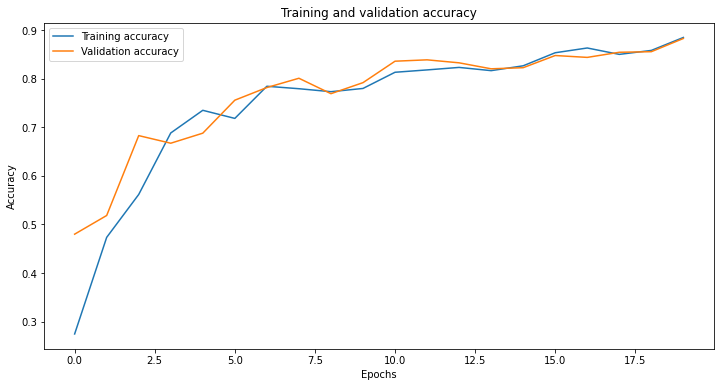

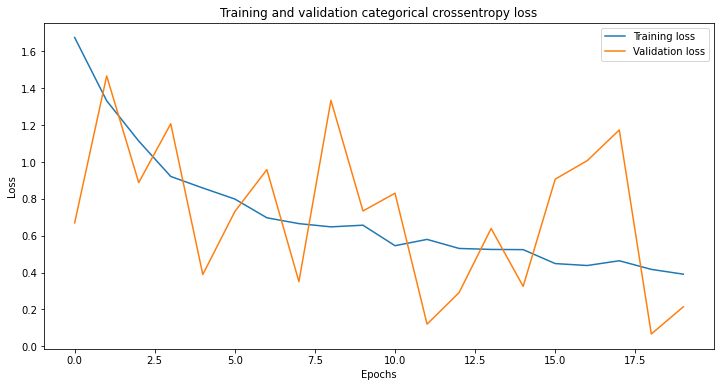

In [10]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Evaluate test dataset

In [11]:
loss, accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples//test_generator.batch_size)

In [12]:
print("Test dataset Accuracy: %f and Loss: %f" % (accuracy,loss))

Test dataset Accuracy: 0.879902 and Loss: 0.973677


### Model Classification and Confusion Matrix

In [13]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

In [14]:
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))    

Classification Report
              precision    recall  f1-score   support

   cardboard       0.99      0.89      0.94       101
       glass       0.85      0.85      0.85        80
       metal       0.79      0.92      0.85        65
       paper       0.84      0.98      0.90        95
     plastic       0.93      0.73      0.82        77

    accuracy                           0.88       418
   macro avg       0.88      0.87      0.87       418
weighted avg       0.89      0.88      0.88       418



Confusion Matrix


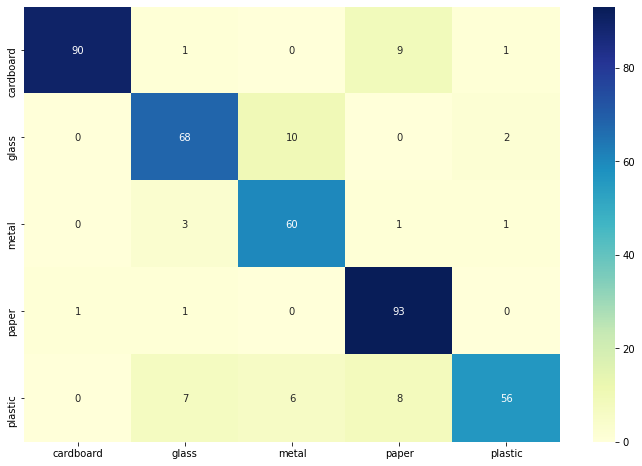

In [15]:
print('Confusion Matrix')
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

### Predict new images

In [16]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

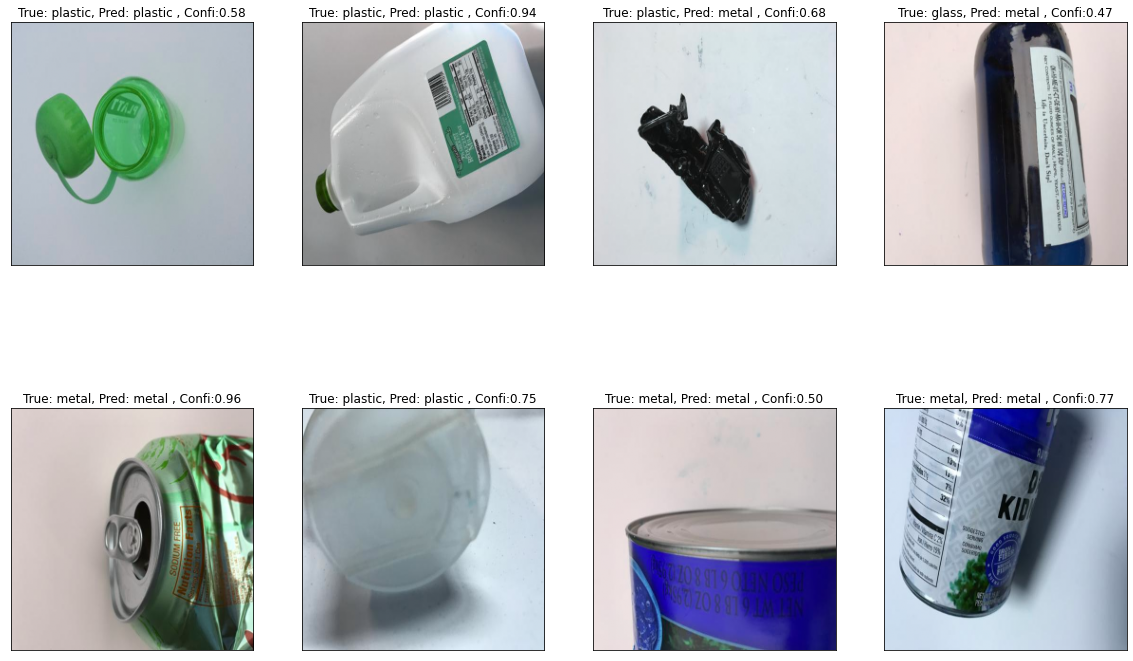

In [21]:
# Plot function

from keras.preprocessing import image

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = model.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save model

In [20]:
model_filename = "DenseNet121.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
    

model.save('CNNModel.h5')